In [32]:
from dotenv import load_dotenv

load_dotenv()

True

In [33]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [34]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
  max_results=3,
  search_depth="advanced",
  include_answer=True,
  include_raw_content=True,
  include_images=True
)

def web_search(state: AgentState):
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    return {'context': results}

In [35]:
from langchain_openai import ChatOpenAI
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)
def web_generate(state: AgentState):
  context = state['context']
  query = state['query']
  rag_chain = generate_prompt | generate_llm | StrOutputParser()
  response = rag_chain.invoke({'question': query, 'context': context})
  return {'answer' : response}

In [36]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model='gpt-4o-mini')

def basic_generate(state: AgentState):
    query = state["query"]
    basic_llm_chain = basic_llm | StrOutputParser()
    llm_response = basic_llm_chain.invoke(query)
    return {'answer': llm_response}

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
       description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", '{query}'),
])

router_llm = ChatOpenAI(model='gpt-4o', temperature=0)
structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState):
  query = state['query']
  router_chain = router_prompt | structured_router_llm
  route = router_chain.invoke({'query': query})
  print(f"Routing to: {route}")
  return route.target

In [38]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [39]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
  START,
  router,
  {
    'vector_store': 'income_tax_agent',
    'llm': 'basic_generate',
    'web_search': 'web_search',
  } 
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [40]:
graph = graph_builder.compile()

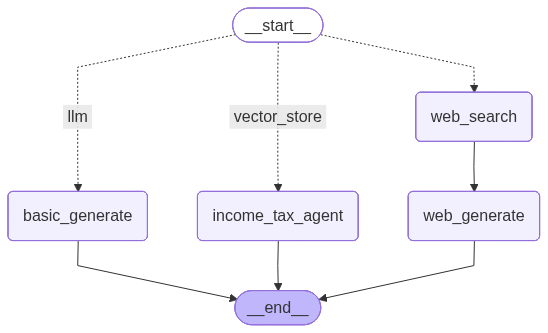

In [41]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [42]:
initial_state = {'query' : '역삼역 맛집 추천해줘'}
graph.invoke(initial_state)

Routing to: target='web_search'


TypeError: unhashable type: 'Route'